<a href="https://colab.research.google.com/github/victor-pontes/Portfolio/blob/master/Predicao_diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predição de Diabetes Segundo o Perfil Populacional Brasileiro**

Apresento neste notebook os modelos para predição de diabetes segundo o inquérito VIGITEL 2017. <br>
[Ver descrição do estudo](https://victor-pontes.github.io/Portfolio/)

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV

In [0]:
# leitura dos dados
all2017 = pd.read_csv('https://raw.githubusercontent.com/victor-pontes/Predicao_diabetes/master/all2017.csv')

Criando dicionário com a especificação da natureza das variáveis.

In [0]:
dict = pd.read_excel('https://github.com/victor-pontes/Predicao_diabetes/blob/master/Dic_dados_2017.xlsx?raw=true', header=None)
dict = dict[dict[0].notnull() & dict[4].notnull()]
dict.drop([2], inplace=False, axis=0)
dict = pd.Series(dict[4].array, index=dict[0].array)

In [0]:
dict.tail()

pesorake                                               pesorake
q9_i                              peso (kg) - valores imputados
q11_i                           altura (cm) - valores imputados
q59a_horas      RECODE of q59a (quantas horas assiste tv / dia)
q59c_horas    RECODE of q59c (em média, este uso do computad...
dtype: object

### Análise Prévia:

In [0]:
all2017.shape

(53034, 198)

Trata-se de um problema dominado pela seleção de features, uma vez que a quantidade de variáveis é muito grande em relação ao total de registros. Para uma simples ilustração, um conjunto de 20 features binárias pode produzir mais de 1 milhão de combinações (2² = 1048576). Esta situação é conhecida como a **maldição da dimensionalidade**.
Como perspectiva inicial, segundo minha experiência, o número de features deverá ser reduzido à valores de **20 a 30 features**



# Limpeza de dados

In [0]:
# A variável chave não é relevante para análise pois nenhum usuário será identificado, sendo eles diferenciado pelo index. 
# A variável é irrelevante por não apresentar variância, sempre é 2017. Será removida
all2017.drop(['chave', 'ano'], axis=1, inplace=True) 

In [0]:
noise_cols =  ['r135', 'r136', 'r153', 'r137a', 'r154', 'r155', 'r156', 'r178']
print(dict[noise_cols])

r135                     nos últimos 12 meses foi multado?
r136                                          qual o local
r153                                       passou em blitz
r137a                                      parado em blitz
r154                                   convidado bafometro
r155                                       fez o bafometro
r156                                          deu positivo
r178     nos últimos 30 dias, uso de celular durante a ...
dtype: object


In [0]:
# noise_cols: informações de blitz é apenas ruído
all2017.drop(noise_cols, axis=1,inplace=True)

In [0]:
leakage_cols = ['r202', 'r204', 'r133a', 'r134c', 'd3', 'r133b', 'r134b', 'd1']
print(dict[leakage_cols])  # Nem foram capturadas pelo dict

r202                           idade do ínicio do diabetes
r204                                                   NaN
r133a                                  comprimido diabetes
r134c                                                  NaN
d3       nos últimos 30 dias, ficou sem os comprimidos ...
r133b                                    insulina diabetes
r134b                      onde consegue insulina diabetes
d1               nos últimos 30 dias, ficou sem a insulina
dtype: object


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1155: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [0]:
# Informações referentes ao tratamente do diabetes são target leakages
all2017.drop(leakage_cols, axis=1,inplace=True)

## Tratando Missing Values

In [0]:
# Function to display missing percentages
def missing_percentage(df): 
    total = df.isnull().sum().sort_values(ascending = False)
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)
    missed_values = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
    return missed_values[missed_values.Total > 0]

In [0]:
missed_values = missing_percentage(all2017)
missed_values.head()

,Total,Percent
q61a_fx,52350,98.71
q61a,52350,98.71
r157,50628,95.46
q61_fx,50024,94.32
q61,50024,94.32


In [0]:
missed_values.describe()

,Total,Percent
count,69.000000,69.000000
mean,29294.782609,55.237681
std,16537.900504,31.182288
min,638.000000,1.200000
25%,19504.000000,36.780000
50%,32663.000000,61.590000
75%,44080.000000,83.120000
max,52350.000000,98.710000


### Analisando Fumantes

Observa-se um alto grau de valores perdidos nas variáveis que registram o comportamento dos entrevistados quanto ao consumo do cigarro, portanto analisaremos as razões

In [0]:
print(dict[['q60', 'q61_fx', 'q61a_fx', 'q62', 'q63','q64', 'q67', 'q68']])

q60                                          fumante
q61_fx       cigarros diário (agrupamento em faixas)
q61a_fx     cigarros semanal (agrupamento em faixas)
q62                              idade inÍcio (anos)
q63                                     tentou parar
q64                                       ex-fumante
q67                          contato c/ fumo em casa
q68                      contato c/ fumo no trabalho
dtype: object


In [0]:
all2017['q60'].isnull().any()

False

In [0]:
temp = all2017['q60'].value_counts()
print(f'{temp[2]+temp[1]} pessoas são fumantes declaradas, \
o que representa {(temp[2]+temp[1])/temp.sum()*100:.2f}% da amostra.')
print(f'{temp[1]} pessoas são fumantes diárias declaradas, \
o que representa {temp[1]/temp.sum()*100:.2f}% da amostra.')

3694 pessoas são fumantes declaradas, o que representa 6.97% da amostra.
3010 pessoas são fumantes diárias declaradas, o que representa 5.68% da amostra.


In [0]:
# Cigarros Diários: só responderam os fumantes diários declarados 
missed_values.loc['q61']

Total      50024.00
Percent       94.32
Name: q61, dtype: float64

In [0]:
all2017['q61'].value_counts()

20.0     765
10.0     552
5.0      239
15.0     234
4.0      150
3.0      149
8.0      121
6.0      118
888.0    107
40.0     107
2.0       98
30.0      86
12.0      68
7.0       60
1.0       35
25.0      22
18.0      18
13.0      15
14.0      14
60.0      14
9.0       13
17.0       8
16.0       4
50.0       3
24.0       3
11.0       2
36.0       1
29.0       1
28.0       1
19.0       1
35.0       1
Name: q61, dtype: int64

In [0]:
# Não fumantes: 0 cigarros diários
all2017['q61'] = all2017['q61'].fillna(0)

In [0]:
# Idade que começou a fumar: só responderam os fumantes declarados
missed_values.loc['q62']

Total      49340.00
Percent       93.03
Name: q62, dtype: float64

In [0]:
all2017['q62'] = all2017['q62'].fillna(999) 

In [0]:
# Ex fumantes: os fumantes não responderam
print(dict['q64'])
missed_values.loc['q64']

ex-fumante


Total      3694.00
Percent       6.97
Name: q64, dtype: float64

In [0]:
# valores nulos - fumantes: input (0) --   0: Fumante, 1:Ex-fumante diário, 2:Ex-fumante não diário, 3:Nunca fumou 
all2017['q64'] = all2017['q64'].fillna(0) 

In [0]:
print(dict['q67'])
print(dict['q68'])

contato c/ fumo em casa
contato c/ fumo no trabalho


In [0]:
print(missed_values.loc['q67']['Percent'])
print(missed_values.loc['q68']['Percent'])

18.1
50.51


In [0]:
# Fillna 999 
all2017['q67'] = all2017['q67'].fillna(999)
all2017['q68'] = all2017['q68'].fillna(999)

In [0]:
# q61a - cigarros semanal
print(dict['q61_fx'],'\n', dict['q61a_fx'], '\n', dict['q63'])

cigarros diário (agrupamento em faixas) 
  cigarros semanal (agrupamento em faixas) 
 tentou parar


In [0]:
noise_cols = ['q61a', 'q61_fx', 'q61a_fx', 'q63']
all2017.drop(noise_cols, axis=1,inplace=True)

In [0]:
missed_values = missing_percentage(all2017)
missed_values.head(10)

,Total,Percent
r157,50628,95.46
r138,49214,92.80
q54,49033,92.46
q40,48065,90.63
r148_mm,47001,88.62
r148_hh,47001,88.62
r147,47001,88.62
q38,46331,87.36
r200,45879,86.51
q39,45879,86.51


In [0]:
missed_values.shape

(60, 2)

In [0]:
# Para as demais variáveis, input 999
all2017 = all2017.fillna(999)

### Avaliando Target: rótulo diabetes

In [0]:
# Renomeando Target
all2017.rename(columns={'q76': "Diabetes"}, inplace=True)

In [0]:
value_diabetes = all2017['Diabetes'].value_counts()
value_diabetes

2      47007
1       5956
777       71
Name: Diabetes, dtype: int64

In [0]:
print(f'{value_diabetes[1]} se declararam diabéticos, \
o que representa {100*value_diabetes[1]/value_diabetes.sum():.2f}% dos entrevistados')

5956 se declararam diabéticos, o que representa 11.23% dos entrevistados


Transformando em variável binária:


* 0: Não declarado diabético

* 1: Diabético declarado



In [0]:
all2017['Diabetes'] = all2017['Diabetes'].apply(lambda x: 1 if x == 1 else 0) 

Procurando por Target Leakage

In [0]:
corr = all2017.corr()['Diabetes'][:]
corr = corr.apply(lambda x:abs(x)).sort_values(ascending=False)
corr.head(10)

diab           1.000000
db             1.000000
Diabetes       1.000000
ind_med_db     0.970631
trat_med_db    0.940840
med_db         0.917750
r138           0.781213
insulina       0.405545
med_has        0.274567
r174           0.274198
Name: Diabetes, dtype: float64

In [0]:
# Removendo variáveis iguais db e diab, e outras relativas ao tratamente de diabetes, o que só se realiza em diabéticos.
leakage_cols = ['db', 'diab', 'ind_med_db', 'trat_med_db', 'med_db','insulina']
all2017.drop(leakage_cols, axis=1,inplace=True)

In [0]:
dict['r138']

'diabetes apenas na gravidez'

Observa-se altíssima correlação entre a diabetes e a variável **r138** que indica diabete apenas na gravidez. Tal variável é um exemplo claro de **target leakage** pois carrega consigo a informação de que a mulher que teve diabetes gestacional, não tem diabetes do tipo 1 e 2.

Nenhuma relação tornaria a variável útil em abiente em produção, portanto, a mesma **deve ser removida.**

In [0]:
all2017.drop(['r138'], axis=1, inplace=True) 

Verificando existência de colunas não numéricas

In [0]:
object_cols = [col for col in all2017.columns if all2017[col].dtype == "object"]
object_cols

['cidade']

In [0]:
all2017.cidade.value_counts()

c16    2070
c17    2067
c11    2063
c07    2063
c13    2056
c26    2055
c19    2053
c23    2051
c10    2048
c22    2048
c25    2041
c05    2032
c21    2031
c09    2027
c06    2026
c01    2025
c24    2020
c15    2018
c03    2008
c08    1970
c02    1920
c27    1906
c18    1846
c20    1831
c04    1674
c14    1646
c12    1439
Name: cidade, dtype: int64

In [0]:
# Convertendo cidade
all2017['cidade'] = all2017['cidade'].str[1:].astype('int64')

In [0]:
all2017.shape

(53034, 169)

# Pré-processamento

Tendo sido realizado alguns estágios de limpeza dos dados, ainda é priciso remover features redundadantes. Dado o ainda valores de features (168), se tornaria dificil visualizar a matriz de correlação entre essas variáveis, desta forma, serão realizadas sucessivas análises das correlação entre as features mais importantes para remoção da redundancia entre as principais features, que serão consideradas na análise

In [0]:
X = all2017.drop(['Diabetes'], axis=1) 
y = all2017['Diabetes']

In [0]:
def feature_importance_fun(X, y):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.8, random_state = 42)
    rf = RandomForestClassifier(n_estimators = 100,
                                n_jobs = -1,
                                oob_score = True,
                                bootstrap = True,
                                random_state = 42)
    rf.fit(X_train, y_train)

    print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(rf.score(X_train, y_train), 
                                                                                                 rf.oob_score_,
                                                                                                 rf.score(X_valid, y_valid)))
    
    feature_importance = pd.Series(rf.feature_importances_, index=X.columns.array).sort_values(ascending=False)
    return feature_importance

In [0]:
feature_importance = feature_importance_fun(X,y)

R^2 Training Score: 1.00 
OOB Score: 0.89 
R^2 Validation Score: 0.89


In [0]:
feature_importance.head(30)

q6              0.026240
imc_i           0.026075
pesorake        0.023361
imc             0.022008
q9_i            0.020220
q9              0.019788
q74             0.019739
q11_i           0.019468
replica         0.019289
cidade          0.019056
q11             0.019049
r130a           0.015730
mesfim          0.015514
q8_anos         0.015143
q59a_horas      0.011927
q59a            0.011725
flvdia          0.011407
q8b             0.011127
q25             0.010924
q8a             0.010501
r180            0.010352
regiao          0.010221
r144b           0.010019
q21             0.009796
q15             0.009744
q23             0.009677
q17             0.009646
faxinasemana    0.009514
r129            0.009499
fet             0.009445
dtype: float64

In [0]:
most_important = list(feature_importance.index[:30])

In [0]:
most_important

['q6',
 'imc_i',
 'pesorake',
 'imc',
 'q9_i',
 'q9',
 'q74',
 'q11_i',
 'replica',
 'cidade',
 'q11',
 'r130a',
 'mesfim',
 'q8_anos',
 'q59a_horas',
 'q59a',
 'flvdia',
 'q8b',
 'q25',
 'q8a',
 'r180',
 'regiao',
 'r144b',
 'q21',
 'q15',
 'q23',
 'q17',
 'faxinasemana',
 'r129',
 'fet']

In [0]:
def matriz_corr(X):
    sns.set(style="white")

    # Compute the correlation matrix
    corr = X.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(14, 12))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5});

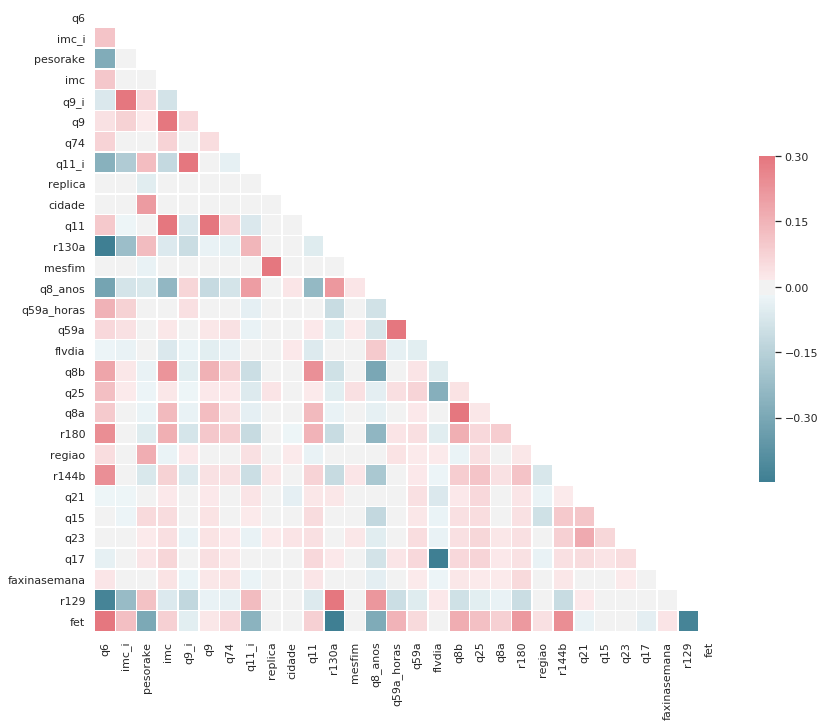

In [0]:
matriz_corr(X[most_important])

In [0]:
def corr_importance(feature):
    corr = X.corr()[feature][:]
    corr = corr.apply(lambda x:abs(x)).sort_values(ascending=False)
    fi = pd.Series(corr.index).apply(lambda x:feature_importance[x])
    return pd.DataFrame({'Corr': corr, 'Importance': list(fi), 'Dict': dict[corr.index]})

In [0]:
correlation = corr_importance('r130a')
correlation.head(10)

,Corr,Importance,Dict
r130a,1.000000,0.015730,onde consegue medicação pressão
med_has,0.996625,0.005164,NaN
r174,0.995988,0.009320,"nos últimos 30 dias, ficou sem medicação pressão"
trat_med_has,0.994147,0.008305,NaN
ind_med_has,0.941980,0.008973,NaN
r129,0.912674,0.009499,medicamento
r203,0.912557,0.005980,NaN
has,0.912336,0.005807,NaN
hart,0.912336,0.006376,NaN
fet,0.447445,0.009445,Faixa etária


In [0]:
# Remove Redundant Features
redundant_features = list(set(correlation[:9].index) - {'r130a'})
X.drop(redundant_features, axis=1,inplace=True)
all2017.drop(redundant_features, axis=1,inplace=True)

### Repetindo o Processo

R^2 Training Score: 1.00 
OOB Score: 0.89 
R^2 Validation Score: 0.89


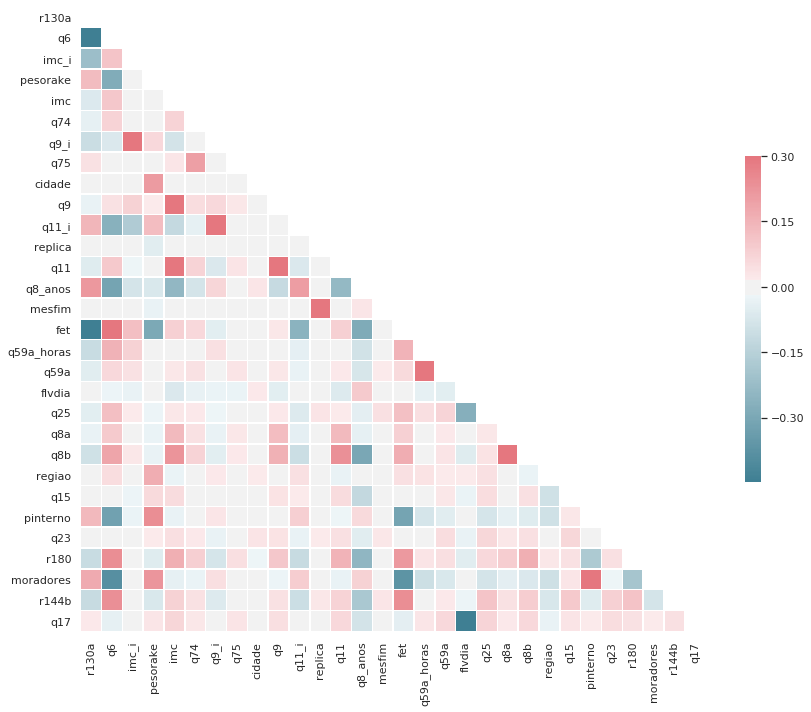

In [0]:
feature_importance = feature_importance_fun(X,y)
most_important = list(feature_importance.index[:30])
matriz_corr(X[most_important])

Vê se agora um baixo nível de correlação entre as principais variáveis restantes (observar legenda).

# Feature Selection

Em conjuntos de dados densos e com muita features, uma estratégia tem se mostrado adequada para feature selection: seleção inicial de features por método de Filtering para redução de 50% a 90% das features iniciais, seguida da aplicação de algorítmo de Wrapping para a redução de features até o nível desejado.

Uma maneira de aplicar esta estratégia seria filtrar algumas features pela sua importância no método RandomForest como desenvolvido acima e em seguida, aplicar um wrapper como o Recursive Feature Elimination (RFE). Todavia, por motivos didáticos, a remoção das features se dará exclusivamente pelo RFE. Tal estratégia é mais eficaz (melhor precisão), porém menos eficiente (mais lenta).

In [0]:
clf = RandomForestClassifier(n_estimators=100) 
rfecv = RFECV(estimator=clf, step=1, cv=2,scoring='roc_auc')   #2-fold cross-validation
rfecv = rfecv.fit(X, y)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X.columns[rfecv.support_])

Optimal number of features : 149
Best features : Index(['replica', 'mesfim', 'cidade', 'regiao', 'q6', 'q7', 'civil', 'q8a',
       'q8b', 'q8_anos',
       ...
       'q59c_horas', 'tempo_tela_total', 'saruim', 'iddmamo', 'mamo',
       'mamodois', 'iddpapa_old', 'iddpapa', 'papa', 'papatres'],
      dtype='object', length=149)


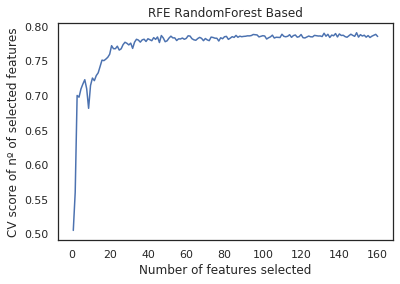

In [0]:
# Plot number of features VS. cross-validation scores: roc-auc, 2-folds, 100 estimatos
plt.figure()
plt.title('RFE RandomForest Based')
plt.xlabel("Number of features selected")
plt.ylabel("CV score of nº of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [0]:
clf = XGBClassifier(n_estimators=100) 
rfecv = RFECV(estimator=clf, step=1, cv=2,scoring='roc_auc')   #2-fold cross-validation
rfecv = rfecv.fit(X, y)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X.columns[rfecv.support_])

Optimal number of features : 5
Best features : Index(['q6', 'q30a', 'q74', 'q75', 'r130a'], dtype='object')


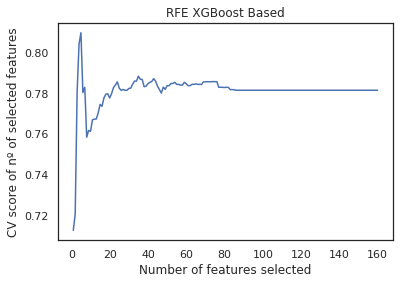

In [0]:
# Plot number of features VS. cross-validation scores: roc-auc, 2-folds, 100 estimatos
plt.figure()
plt.title('RFE XGBoost Based')
plt.xlabel("Number of features selected")
plt.ylabel("CV score of nº of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Das gráficos acima, observa-se que o número de 30 features é razoável. 

In [0]:
# Coleta e apresentação das 30 features selecionadas pelo RFECV baseano no XGBoost

transform = np.vectorize(lambda x: True if x <=26 else False)
best_features = transform(rfecv.ranking_)
best_features = X.columns[best_features]
pd.DataFrame({'Features': best_features, 'Importance': list(feature_importance[best_features]),
              'Dict': list(dict[best_features])}).sort_values('Importance', ascending=False).reindex(range(30))

,Features,Importance,Dict
0,q6,0.027922,idade (anos)
1,q8_anos,0.016131,anos de estudo
2,q9,0.020310,peso (kg)
3,q27,0.007658,freq fruta
4,q28a,0.003443,ontem fruta
5,q29a,0.006124,ontem refrigerante/suco artificial
6,q30a,0.004155,que tipo refrigerante/suco artificial
7,q35,0.002654,bebida alcoólica
8,q36,0.005167,freq alcool
9,q38,0.001578,4 doses (mulher)


# Modelagem

In [0]:
def avaliation(X, y):
    seeds = [0, 1, 7, 42]
    RF_auc = RF_acc = []

    XGB = XGBClassifier(n_estimators=100)
    XGB_score = cross_validate(XGB, X, y, cv=4, n_jobs=-1, scoring = ['accuracy', 'roc_auc']) 
    result_XGB = [XGB_score['test_roc_auc'].mean(), XGB_score['test_accuracy'].mean()]

    LGBM = LGBMClassifier(random_state=50)
    LGBM_score = cross_validate(LGBM, X, y, cv=4, n_jobs=-1, scoring = ['accuracy', 'roc_auc']) 
    result_LGBM = [LGBM_score['test_roc_auc'].mean(), LGBM_score['test_accuracy'].mean()]

    GBM = GradientBoostingClassifier(random_state=0)
    GBM_score = cross_validate(GBM, X, y, cv=4, n_jobs=-1, scoring = ['accuracy', 'roc_auc']) 
    result_GBM = [GBM_score['test_roc_auc'].mean(), GBM_score['test_accuracy'].mean()]

    for random_state in seeds:
        RF = RandomForestClassifier(random_state=random_state)
        RF_score = cross_validate(RF, X, y, cv=4, n_jobs=-1, scoring = ['accuracy', 'roc_auc']) 
        RF_auc = RF_auc + [RF_score['test_roc_auc'].mean()]
        RF_acc = RF_acc + [RF_score['test_accuracy'].mean()]

    result_RF = [np.array(RF_auc).mean(), np.array(RF_acc).mean()]

    results = [result_RF, result_XGB, result_LGBM, result_GBM]
    
    return(pd.DataFrame(results,columns=['ROC-AUC', 'Accuracy'], index=['RandomForest', 'XGB', 'LGBM', 'GBM']))

In [0]:
# Todas as features
avaliation(X,y)

,ROC-AUC,Accuracy
RandomForest,0.726186,0.883358
XGB,0.815573,0.869858
LGBM,0.793160,0.835259
GBM,0.808487,0.867369


In [0]:
# best features
avaliation(X[best_features], y)

,ROC-AUC,Accuracy
RandomForest,0.739897,0.882561
XGB,0.824864,0.889373
LGBM,0.821865,0.888109
GBM,0.824245,0.889279
